In [1]:
! pip install -q kaggle

In [2]:
import os
import shutil
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed = 37
g = torch.Generator().manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# plt.rcParams['text.usetex'] = False

In [4]:
input_shape = (3,129,129) #Formats: {torch (c, h, w), cv2 (h, w, c)}, {plt and PIL  (w, h, c)}
batch_size = 128
lr = 8e-5
epochs = 60
val_size = 0.1

In [5]:
iskaggle = False
base_dir = '/kaggle/working' if iskaggle else '/content'

## Data

### Downloading

In [6]:
import tarfile

save_path = f'{base_dir}/voc2005_1.tar.gz'

!wget -q -O $save_path http://host.robots.ox.ac.uk/pascal/VOC/download/voc2005_1.tar.gz

with tarfile.open(base_dir+'/voc2005_1.tar.gz', 'r:gz') as tar_ref:
    tar_ref.extractall(base_dir)


In [7]:
background_dir = f'{base_dir}/Background/'
downloaded_bg = f'{base_dir}/monet2photo.zip'

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d balraj98/monet2photo

! mkdir $background_dir
!unzip -q $downloaded_bg -d $background_dir

Dataset URL: https://www.kaggle.com/datasets/balraj98/monet2photo
License(s): other
 90% 263M/291M [00:00<00:00, 295MB/s]
100% 291M/291M [00:01<00:00, 297MB/s]


### Cleaning

In [8]:
objectCategories_path = f'{base_dir}/VOC2005_1/PNGImages/'
annotations_path = f'{base_dir}/VOC2005_1/Annotations/'

In [9]:
img_folders = set(glob('*', root_dir=objectCategories_path))
annot_folders = set(glob('*', root_dir=annotations_path))

## folders in Annotations but not having same name at VOC2005_1 (annot - img)
annotDIFFimgs = annot_folders.difference(img_folders)
## folders in VOC2005_1 but not having same name at Annotations (img - annot)
imgsDIFFannot = img_folders.difference(annot_folders)

diff_paths = annotDIFFimgs.union(imgsDIFFannot)
## Delete Non-existed folders or files
for f in diff_paths:
    if os.path.exists(f):
        if os.path.isdir(f):
            shutil.rmtree(f)
            print('Removed '+ f)
        else:
            os.remove(f)
            print('Removed '+ f)

shutil.rmtree(f'{base_dir}/VOC2005_1/Annotations/UIUC_TestImages') if os.path.exists(f'{base_dir}/VOC2005_1/Annotations/UIUC_TestImages') else None
shutil.rmtree(f'{base_dir}/VOC2005_1/Annotations/UIUC_TestImages_Scale')  if os.path.exists(f'{base_dir}/VOC2005_1/Annotations/UIUC_TestImages_Scale') else None
shutil.rmtree(f'{base_dir}/VOC2005_1/PNGImages/UIUC_TestImages')  if os.path.exists(f'{base_dir}/VOC2005_1/PNGImages/UIUC_TestImages') else None
shutil.rmtree(f'{base_dir}/VOC2005_1/PNGImages/UIUC_TestImages_Scale')  if os.path.exists(f'{base_dir}/VOC2005_1/PNGImages/UIUC_TestImages_Scale') else None

os.remove(f'{base_dir}/VOC2005_1/Annotations/TUGraz_cars/carsgraz_310.txt') if os.path.exists(f'{base_dir}/VOC2005_1/Annotations/TUGraz_cars/carsgraz_310.txt') else None
os.remove(f'{base_dir}/VOC2005_1/PNGImages/TUGraz_cars/carsgraz_310.png') if os.path.exists(f'{base_dir}/VOC2005_1/PNGImages/TUGraz_cars/carsgraz_310.png') else None

os.remove(f'{base_dir}/VOC2005_1/Annotations/TUGraz_cars/carsgraz_330.txt') if os.path.exists(f'{base_dir}/VOC2005_1/Annotations/TUGraz_cars/carsgraz_330.txt') else None
os.remove(f'{base_dir}/VOC2005_1/PNGImages/TUGraz_cars/carsgraz_330.png') if os.path.exists(f'{base_dir}/VOC2005_1/PNGImages/TUGraz_cars/carsgraz_330.png') else None
print('Done')

Done


### Data integrity check
checks that each image path corresponding to its annotation path

In [10]:
img_paths = sorted(glob(objectCategories_path + '*/*.png'))
annot_paths = sorted(glob(annotations_path + '*/*.txt'))

for idx,(x,y) in enumerate(zip(img_paths, annot_paths)):
    x_split, y_split = x.split('/'), y.split('/')
    if x_split[-2] != y_split[-2] or y_split[-1].split('.')[0] != x_split[-1].split('.')[0]:
        print(f'bad matching between: {x} and {y}')


### Spliting

In [11]:
img_folders_cleand = sorted(glob('*', root_dir=objectCategories_path))
img_folders_cleand = ['MotorBike', 'Car', 'Bike', 'Person']
cls_to_idx = {i:j for j,i in enumerate(img_folders_cleand)}
idx_to_cls = {i:j for j,i in cls_to_idx.items()}

img_paths = sorted(glob(objectCategories_path + '*/*.png'))
annot_paths = sorted(glob(annotations_path + '*/*.txt'))
bg_img_paths = sorted(glob(base_dir+'/Background/testB/*.jpg'))
bg_labels = [0] * len(bg_img_paths)

img_paths += bg_img_paths
annot_paths += bg_labels

train_img_paths, temp_img_paths, train_annot_paths, temp_annot_paths = train_test_split(img_paths, annot_paths, test_size=val_size*2, random_state=seed, shuffle=True)
test_img_paths, val_img_paths, test_annot_paths, val_annot_paths = train_test_split(temp_img_paths, temp_annot_paths, test_size=0.5, random_state=seed, shuffle=True)


print(f"All images: {len(img_paths)} \t All annotations: {len(annot_paths)}")
print(f"Training images: {len(train_img_paths)} \t Training annotations: {len(train_annot_paths)}")
print(f"Validation images: {len(val_img_paths)} \t Validation annotations: {len(val_annot_paths)}")
print(f"Test images: {len(test_img_paths)} \t Test annotations: {len(test_annot_paths)}")

All images: 1910 	 All annotations: 1910
Training images: 1528 	 Training annotations: 1528
Validation images: 191 	 Validation annotations: 191
Test images: 191 	 Test annotations: 191


### Loading and preprocessing (DataPipeline)

In [12]:
class Custom_caltech(Dataset):
    def __init__(self, img_paths, annot_paths, targets_dict, transform=None):
        super(Custom_caltech, self).__init__()
        self.img_paths = img_paths
        self.annot_paths = annot_paths
        self.transform = transform
        self.targets_dict = targets_dict

    def __len__(self):
        return len(self.img_paths)

    @staticmethod
    def distance_from_center(bbox, w, h):
        if bbox == []:
            return 9999
        bbox_center = (bbox[2]-bbox[0], bbox[3]-bbox[1])
        distance = ((bbox_center[0]-w/2)**2 + (bbox_center[1]-h/2)**2)**0.5
        return distance

    @staticmethod
    def get_all_bboxes(annot_path, w, h):

        # Read the annotation file
        bbox_data = open(annot_path).read()
        # Get max object index
        max_obj = re.search(r'Objects with ground truth : (\d+)', bbox_data)
        max_obj = int(max_obj.groups()[0])
        all_bboxes = []
        for i in range(1,max_obj+1):
            pattern = r'Bounding box for object {x}.*\((\d+), (\d+)\) - \((\d+), (\d+)\)'.format(x=i)
            bbox_xyxy = re.search(pattern, bbox_data)
            if not bbox_xyxy:
                continue

            bbox_xyxy = list(map(int, bbox_xyxy.groups()))

            if bbox_xyxy[0] >= bbox_xyxy[2] or bbox_xyxy[1] >= bbox_xyxy[3]:
                continue
            bbox_xyxy[2] = w if bbox_xyxy[2]>w else bbox_xyxy[2]
            bbox_xyxy[3] = h if bbox_xyxy[3]>h else bbox_xyxy[3]
            all_bboxes.append(bbox_xyxy)
        return all_bboxes

    def __getitem__(self, index):

        img_path = self.img_paths[index]
        annot_path = self.annot_paths[index]

        # Load and convert the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Get image dimensions
        h, w = image.shape[:2]

        ## set bboxes to anything incase background images
        all_bboxes = [[0, 0, w, h]] if annot_path == 0 else Custom_caltech.get_all_bboxes(annot_path, w, h)
        if len(all_bboxes) <= 0:
            all_bboxes = [[0, 0, w, h]]

        if self.transform:
            augmentations = self.transform(image=np.array(image), bboxes=all_bboxes)
            image = augmentations['image']
            all_bboxes = augmentations['bboxes']
            h, w = image.shape[1:3]  # Update dimensions after transformation

        image = image / 255.0

        # Normalize bounding box coordinates
        sorted_bboxes = sorted(all_bboxes, key=lambda bbox: Custom_caltech.distance_from_center(bbox, w, h))
        chosen_bbox = np.array(sorted_bboxes[0]) / [w, h, w, h]
        # Clip bounding box to ensure coordinates are within [0, 1]
        chosen_bbox = chosen_bbox.clip(0, 1)
        # Get the label
        label = next((value for cls, value in self.targets_dict.items() if cls.lower() in img_path.lower()), -1)

        #########################
        objectness = 0 if annot_path == 0 else 1
        #########################
        return image, torch.tensor(objectness).float(), torch.tensor(label).long(), torch.tensor(chosen_bbox).float()

In [13]:
aug_transform = A.Compose([
    A.HorizontalFlip(p=0.6),

    A.RandomScale(scale_limit=(-0.2, 0.02), p=0.7),
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),

    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.GaussianBlur(p=0.3),

    A.Resize(p=1.0, height=input_shape[1], width=input_shape[2]),
    ToTensorV2()], bbox_params=A.BboxParams('pascal_voc', min_visibility=0.4, label_fields=[]))


ds_train = Custom_caltech(train_img_paths, train_annot_paths, cls_to_idx, transform=aug_transform)

ds_val = Custom_caltech(val_img_paths, val_annot_paths, cls_to_idx,
                             transform=A.Compose([A.Resize(p=1.0, height=input_shape[1], width=input_shape[2]), ToTensorV2()],
                                                 bbox_params=A.BboxParams('pascal_voc', min_visibility=0.3, label_fields=[])))

ds_test = Custom_caltech(test_img_paths, test_annot_paths, cls_to_idx,
                             transform=A.Compose([A.Resize(p=1.0, height=input_shape[1], width=input_shape[2]), ToTensorV2()],
                                                 bbox_params=A.BboxParams('pascal_voc', min_visibility=0.3, label_fields=[])))


### Visualization

In [14]:
def plot(df, rows, cols, targets_dict, transform=None):
    fig, axs = plt.subplots(rows,cols, figsize=(12,5))
    axs = axs.ravel()
    _len = len(df)
    for idx, ax in  enumerate(axs):
        rand_number = torch.randint(0, _len, (1,)).item()
        # print(rand_number)
        image, objectness, label, bbox = df[rand_number]
        # bbox = bbox[0]
        class_name = targets_dict[label.item()] if objectness else 'Background'

        if transform:
            image = transform(image)

        w, h = image.size
        image = cv2.rectangle(np.array(image), (int(bbox[0]*w),int(bbox[1]*h)), (int(bbox[2]*w),int(bbox[3]*h)), (0,255,0),1) if objectness else image
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')


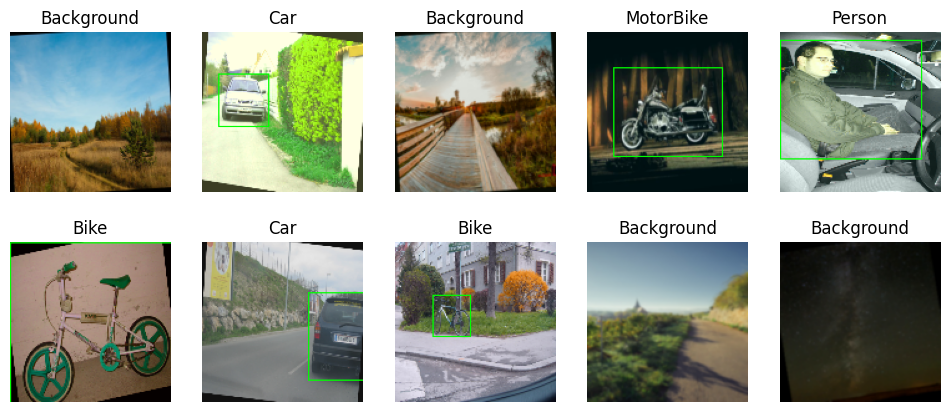

In [15]:
plot(ds_train, 2, 5, idx_to_cls, transform=torchvision.transforms.ToPILImage())

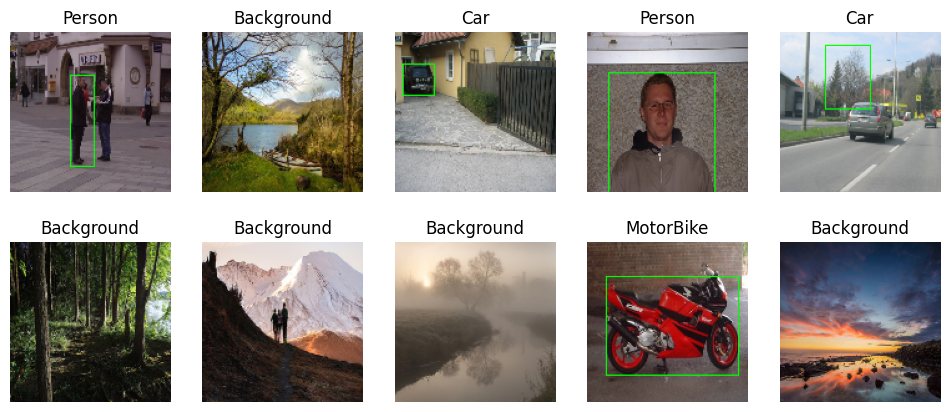

In [16]:
plot(ds_val, 2, 5, idx_to_cls, transform=torchvision.transforms.ToPILImage())

## Model

In [17]:
## Helper
@torch.no_grad()
def loss_acc_loader(model, data_loader, device):
    model.eval()

    total_class_loss = 0
    total_bbox_loss = 0
    total_objectness_loss = 0
    for data, objectness, labels, bbox in data_loader:
        data = data.to(device)
        objectness = objectness.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)

        objectness_logits, class_logits, bbox_logits = model(data)

        total_objectness_loss += objectness_criterion(objectness_logits.view(-1), objectness).item()
        mask = (objectness == 1)

        if mask.any():
            total_class_loss += class_criterion(class_logits[mask].view(-1,num_classes), labels[mask]).item()
            total_bbox_loss += bbox_criterion(bbox_logits[mask].view(-1,4), bbox[mask]).item()

    avg_objectness_loss = total_objectness_loss / len(data_loader)
    avg_class_loss = total_class_loss / len(data_loader)
    avg_bbox_loss = total_bbox_loss / len(data_loader)

    return avg_objectness_loss, avg_class_loss, avg_bbox_loss


def get_parameters_info(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    nontrainable = sum(p.numel() for p in model.parameters() if p.requires_grad==False)

    return trainable, nontrainable

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


### Defining

In [18]:
num_classes = len(cls_to_idx)
# num_classes = 4

class ThreeHeadNetwork(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ThreeHeadNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        self.basemodel = nn.Sequential(nn.Conv2d(3, 64, (9,9), stride=2, padding=4),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.MaxPool2d((3,3), stride=2, padding=1),

                                       nn.Conv2d(64, 256, (7,7), stride=2, padding=3),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.MaxPool2d((3,3), stride=2, padding=1),

                                       nn.Conv2d(256, 256, (5,5), stride=2, padding=2),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256, 512, (5,5), stride=1, padding=0),)

        self.objectness_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.3),
                                             nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                             nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                             nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                             nn.Conv2d(32, 1, (1,1), stride=1, padding=0), nn.Sigmoid())

        self.bbox_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.3),
                                        nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                        nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                        nn.Conv2d(32, 4, (1,1), stride=1, padding=0), nn.Sigmoid())

        self.class_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                        nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                        nn.Conv2d(32, self.num_classes, (1,1), stride=1, padding=0))

    def forward(self, x):
        features = self.basemodel(x)

        objectness_out = self.objectness_head(features)
        class_out = self.class_head(features)
        bbox_out = self.bbox_head(features)

        return objectness_out, class_out, bbox_out

In [19]:
threeHeadMob = ThreeHeadNetwork(input_shape, num_classes).to(device)
tr, nontr = get_parameters_info(threeHeadMob)
print(f"Total trainable parameters= {tr}\nTotal non-trainable parameters= {nontr}")

class_criterion = nn.CrossEntropyLoss()  # Classification loss
bbox_criterion = nn.SmoothL1Loss() # bbox loss
objectness_criterion = nn.BCELoss() # objectness loss

optim = torch.optim.Adam(threeHeadMob.parameters(), lr)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

Total trainable parameters= 6262665
Total non-trainable parameters= 0


### Training Loop

In [20]:
total_batches = len(train_loader)
train_objectness_losses = []
val_objectness_losses = []
train_class_losses = []
train_bbox_losses = []
val_class_losses = []
val_bbox_losses = []

for epoch in range(epochs):
    threeHeadMob.train()  # Set the model to training mode

    print(f'Epoch {epoch+1}/{epochs}: ', end='\n')
    for batch_idx, (data, objectness, labels, bbox) in enumerate(train_loader):

        data = data.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)
        objectness = objectness.to(device)

        objectness_pred, class_logits, bbox_pred = threeHeadMob(data)

        # Objectness Loss
        loss_objectness = objectness_criterion(objectness_pred.view(-1), objectness)

        # Create a mask for samples where object exists
        mask = (objectness == 1)

        if mask.any():
            loss_classification = class_criterion(class_logits[mask].view(-1,num_classes), labels[mask])

            loss_bbox = bbox_criterion(bbox_pred[mask].view(-1,4), bbox[mask])

            # Total loss is sum of objectness, classification, and bbox losses
            total_loss = loss_objectness + loss_classification + loss_bbox
        else:
            # If no objects in the batch, total loss is only objectness loss
            total_loss = loss_objectness

        optim.zero_grad()
        total_loss.backward()
        optim.step()

    # Running model on the entire train and validation dataset after each epoch
    train_objectness_loss, train_class_loss, train_bbox_loss = loss_acc_loader(threeHeadMob, train_loader, device)
    train_objectness_losses.append(train_objectness_loss)
    train_class_losses.append(train_class_loss)
    train_bbox_losses.append(train_bbox_loss)

    val_objectness_loss, val_class_loss, val_bbox_loss = loss_acc_loader(threeHeadMob, val_loader, device)
    val_objectness_losses.append(val_objectness_loss)
    val_class_losses.append(val_class_loss)
    val_bbox_losses.append(val_bbox_loss)

    print(f' Train: Objectness Loss {train_objectness_loss:.4f}, Class Loss {train_class_loss:.4f}, Bbox Loss {train_bbox_loss:.4f}')
    print(f' Valid: Objectness Loss {val_objectness_loss:.4f}, Class Loss {val_class_loss:.4f}, Bbox Loss {val_bbox_loss:.4f}')


Epoch 1/60: 
 Train: Objectness Loss 0.6864, Class Loss 1.3889, Bbox Loss 0.0743
 Valid: Objectness Loss 0.6857, Class Loss 1.3919, Bbox Loss 0.0737
Epoch 2/60: 
 Train: Objectness Loss 0.6687, Class Loss 1.3985, Bbox Loss 0.0809
 Valid: Objectness Loss 0.6656, Class Loss 1.3901, Bbox Loss 0.0798
Epoch 3/60: 
 Train: Objectness Loss 0.5824, Class Loss 1.2655, Bbox Loss 0.0859
 Valid: Objectness Loss 0.5638, Class Loss 1.2263, Bbox Loss 0.0813
Epoch 4/60: 
 Train: Objectness Loss 0.4743, Class Loss 1.0309, Bbox Loss 0.0753
 Valid: Objectness Loss 0.4617, Class Loss 0.9522, Bbox Loss 0.0695
Epoch 5/60: 
 Train: Objectness Loss 0.4219, Class Loss 0.9322, Bbox Loss 0.0637
 Valid: Objectness Loss 0.4245, Class Loss 0.8375, Bbox Loss 0.0573
Epoch 6/60: 
 Train: Objectness Loss 0.4100, Class Loss 0.8266, Bbox Loss 0.0551
 Valid: Objectness Loss 0.4312, Class Loss 0.8265, Bbox Loss 0.0499
Epoch 7/60: 
 Train: Objectness Loss 0.3704, Class Loss 0.7482, Bbox Loss 0.0538
 Valid: Objectness Loss 0

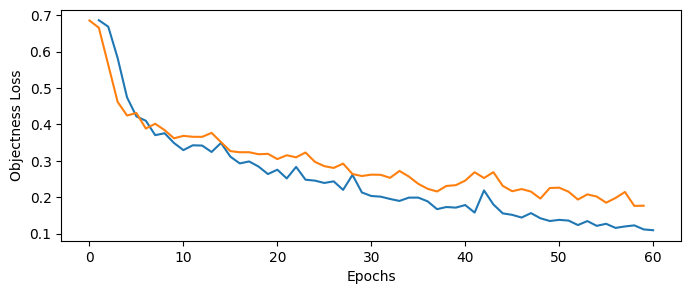

In [21]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_objectness_losses))], train_objectness_losses, val_objectness_losses)
plt.xlabel('Epochs')
plt.ylabel('Objectness Loss')
plt.show()

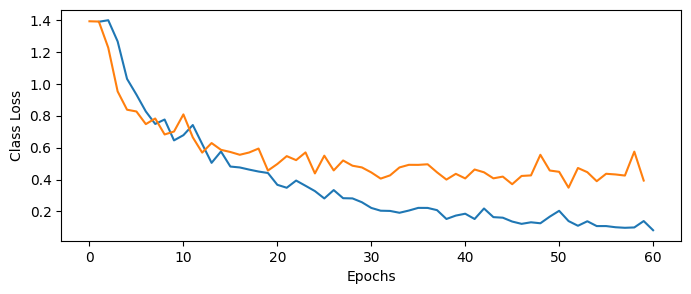

In [22]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_class_losses))], train_class_losses, val_class_losses)
plt.xlabel('Epochs')
plt.ylabel('Class Loss')
plt.show()

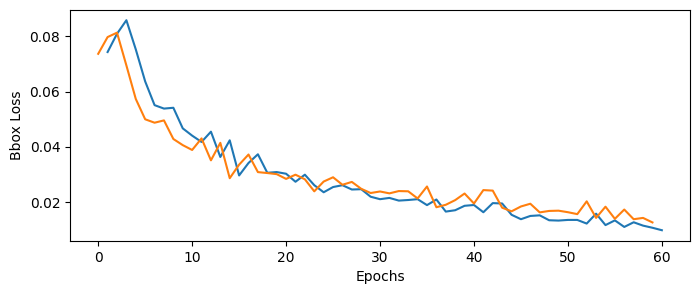

In [23]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_bbox_losses))], train_bbox_losses, val_bbox_losses)
plt.xlabel('Epochs')
plt.ylabel('Bbox Loss')
plt.show()

## Evaluation

In [24]:
test_objectness_loss, test_class_loss, test_bbox_loss = loss_acc_loader(threeHeadMob, test_loader, device)

print(f' Test: Objectness Loss {test_objectness_loss:.4f}, Class Loss {test_class_loss:.4f}, Bbox Loss {test_bbox_loss:.4f}')

 Test: Objectness Loss 0.1697, Class Loss 0.4829, Bbox Loss 0.0096


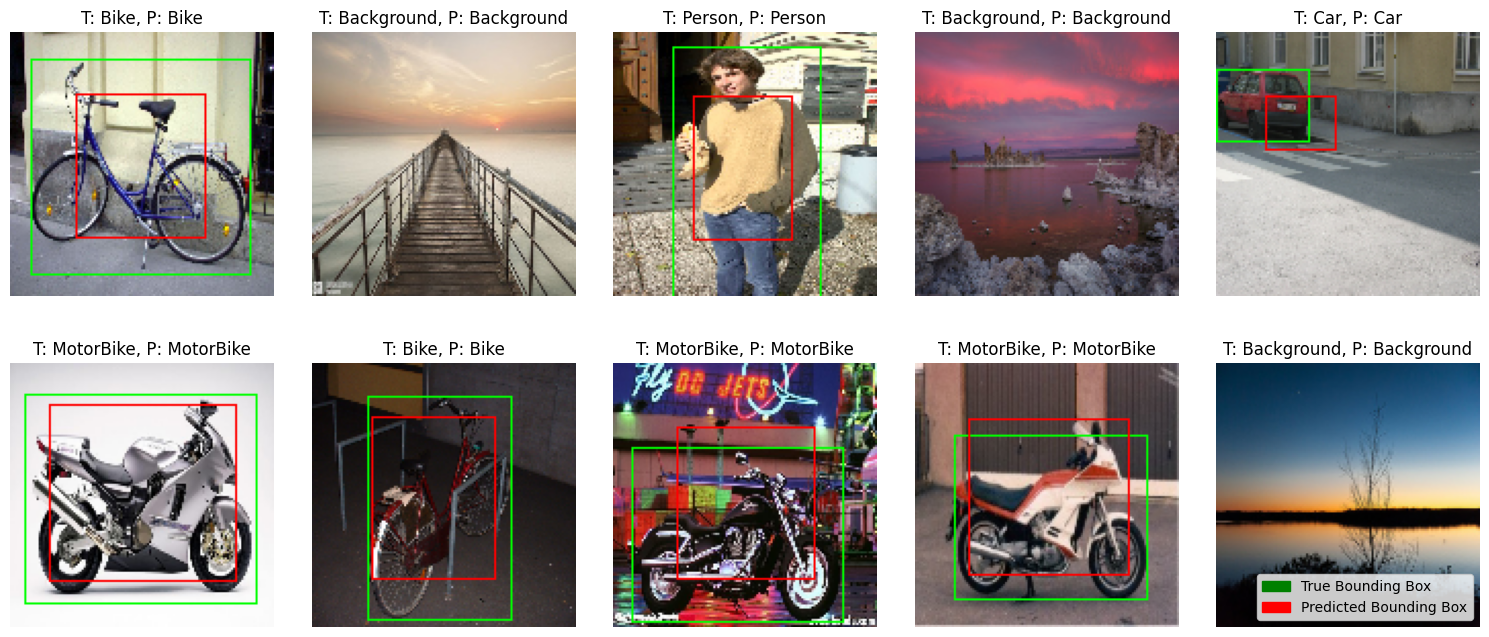

In [25]:
threeHeadMob.eval()

rows=2
cols=5
fig, axs = plt.subplots(rows,cols, figsize=(15,7))
axs = axs.ravel()
pil_tran = torchvision.transforms.ToPILImage()
indices = torch.randint(0, len(ds_test), (rows*cols,))
for ax, idx in zip(axs, indices):
    image, objectness, label, bbox = ds_test[idx]
    image = image.to(device)

    objectness_logits, class_logits, bbox_logits = threeHeadMob(image.unsqueeze(0))
    bbox_logits = bbox_logits.squeeze(0)
    image = pil_tran(image)
    class_name = predicted_name = 'Background'

    if objectness == 1:
        image = cv2.rectangle(np.array(image),
                              (int(bbox[0]*input_shape[2]), int(bbox[1]*input_shape[1])),
                              (int(bbox[2]*input_shape[2]), int(bbox[3]*input_shape[1])), (0,255,0),1)
        class_name = idx_to_cls[label.item()]

    if objectness_logits >= 0.5:
        image = cv2.rectangle(np.array(image),
                              (int(bbox_logits[0].item()*input_shape[2]), int(bbox_logits[1].item()*input_shape[1])),
                              (int(bbox_logits[2].item()*input_shape[2]),int(bbox_logits[3].item()*input_shape[1])), (255,0,0),1)
        predicted_label = torch.argmax(class_logits, dim=1).item()
        predicted_name = idx_to_cls[torch.argmax(class_logits, dim=1).item()]

    ax.imshow(image)
    ax.set_title(f"T: {class_name}, P: {predicted_name}")
#     ax.set_title(f"T: {{\color{{green}} {class_name}}}, P: {{\color{{red}} {predicted_name}}}")
    ax.axis('off')

# Add the legend to the figure
green_patch = mpatches.Patch(color='green', label='True Bounding Box')
red_patch = mpatches.Patch(color='red', label='Predicted Bounding Box')
plt.legend(handles=[green_patch, red_patch], loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

### Saving

In [26]:
model_states = {'model_state': threeHeadMob.state_dict(),
                'optim_state': optim.state_dict(),
                'batch_size': batch_size,
                'classes_dict': cls_to_idx,
                'loss_tr': {'train_objectness_loss': train_objectness_loss, 'train_class_loss': train_class_loss, 'train_bbox_loss': train_bbox_loss},
                'loss_ts': {'test_objectness_loss': test_objectness_loss, 'test_class_loss': test_class_loss, 'test_bbox_loss': test_bbox_loss}}
torch.save(model_states, f'{base_dir}/threeHeadMob_states.pt')

In [27]:
## Save Entire Model
torch.save(threeHeadMob, f'{base_dir}/threeHeadMob_entire.pt')

In [28]:
## deleting non-needed output files
os.remove(f'{base_dir}/monet2photo.zip') if os.path.exists(f'{base_dir}/monet2photo.zip') else None
shutil.rmtree(f'{base_dir}/VOC2005_1') if os.path.exists(f'{base_dir}/VOC2005_1') else None
os.remove(f'{base_dir}/voc2005_1.tar.gz') if os.path.exists(f'{base_dir}/voc2005_1.tar.gz') else None
shutil.rmtree(f'{base_dir}/Background') if os.path.exists(f'{base_dir}/Background') else None